In [1]:
import os, torch, joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from model import *
from utils import *
from data_loader import *
from test_metrics import *
from preprocess.gaussianize import *
from scipy.stats import wasserstein_distance
from statsmodels.tsa.stattools import acf

path = '/workspace/QuantGAN_stock'
try:
    os.chdir(path)
    print("Current working directory: {0}".format(os.getcwd()))
except FileNotFoundError:
    print("Directory {0} does not exist".format(path))
    
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_seed(42)
sns.set(style="darkgrid")


/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Current working directory: /workspace/QuantGAN_stock


In [2]:
# Define the Configuration
full_name = 'num_G_5_400_64_lr_0.0005_hearty-sound-228_clip_0.01'
dataset = "indices"
num_G = 5
seq_len = 127
batch_size = 100

In [3]:
# Load the Real Data for Transformer input
log_returns_preprocessed = joblib.load(f'./Dataset/log_returns_preprocessed.pkl')
data_loader = dataloader(log_returns_preprocessed, seq_len)    
train_loader = torch.utils.data.DataLoader(data_loader, batch_size, shuffle=True)

In [4]:
# Find the best epoch
asset_idx = 0
window = 100
min_emd = 0
best_epochs = 0

min_distance = float('inf')
noise = torch.randn(batch_size, 5, seq_len).to(device)

for epoch in range(100, 400, 2):
    generator_tmp = Generator().to(device)
    generator_tmp.load_state_dict(torch.load(f'./Results/{full_name}/Generator_{epoch}.pt'))
    generator_tmp.eval()
     
    y = generator_tmp(noise).cpu().detach().squeeze()
    y, log_returns = inverse_process(y[:, asset_idx:asset_idx+1, :].squeeze(), asset_idx)
    if y.size == 0:            
        continue
        
    real_dist = rolling_window(log_returns, window).sum(axis=0).ravel()
    fake_dist = rolling_window(y.T, window).sum(axis=0).ravel()       
    
    emd = wasserstein_distance(real_dist, fake_dist)
    if emd < min_distance:
        min_distance = emd
        best_epochs = epoch
        min_emd = min_distance
        print(f"min_distance:{min_distance}, best_epochs:{epoch}")
        
print("best epochs:", best_epochs)

min_distance:0.0298901106250049, best_epochs:100
min_distance:0.029720096906199617, best_epochs:156
min_distance:0.029496706384097026, best_epochs:212
min_distance:0.029307257018741133, best_epochs:214
best epochs: 214


In [5]:
# generate the data based on best epoch
generator = Generator().to(device)
generator.load_state_dict(torch.load(f'./Results/{full_name}/Generator_{best_epochs}.pt'))
generator.eval()

Generator(
  (tcn): ModuleList(
    (0): TemporalBlock(
      (conv1): Conv1d(5, 100, kernel_size=(1,), stride=(1,))
      (chomp1): Chomp1d()
      (relu1): LeakyReLU(negative_slope=0.01)
      (dropout1): Dropout(p=0.2, inplace=False)
      (conv2): Conv1d(100, 100, kernel_size=(1,), stride=(1,))
      (chomp2): Chomp1d()
      (relu2): LeakyReLU(negative_slope=0.01)
      (dropout2): Dropout(p=0.2, inplace=False)
      (net): Sequential(
        (0): Conv1d(5, 100, kernel_size=(1,), stride=(1,))
        (1): LeakyReLU(negative_slope=0.01)
        (2): Dropout(p=0.2, inplace=False)
        (3): Conv1d(100, 100, kernel_size=(1,), stride=(1,))
        (4): LeakyReLU(negative_slope=0.01)
        (5): Dropout(p=0.2, inplace=False)
      )
      (downsample): Conv1d(5, 100, kernel_size=(1,), stride=(1,))
      (relu): LeakyReLU(negative_slope=0.01)
    )
    (1): TemporalBlock(
      (conv1): Conv1d(100, 100, kernel_size=(2,), stride=(1,), padding=(1,))
      (chomp1): Chomp1d()
      (re

In [6]:
fake_list = []
real_list = []
real = []
noise = torch.randn(5000, 5, 127).to(device)
fake = generator(noise).cpu().detach().squeeze()

for i in range(0, num_G):
        
    y_tmp, log_returns = inverse_process(fake[:, i:i+1, :].squeeze(), i)        
    
    y_tmp = y_tmp[(y_tmp.max(axis=1) <= 2.0 * log_returns.max()) & (y_tmp.min(axis=1) >= 2.0 * log_returns.min())]
    print(y_tmp.shape)
    
    fake_list.append(y_tmp)
    real.append(log_returns)

for i in range(len(real)):        
    real_list.append(np.array(rolling_window_seqlen(real[i], 127)).squeeze())
    
# 합성 데이터 저장
joblib.dump(fake_list, './fake_list.pkl')
joblib.dump(real_list, './real_list.pkl')


(4967, 127)
(4967, 127)
(4994, 127)
(4996, 127)
(4999, 127)


['./real_list.pkl']

In [7]:
print(type(real))
print(len(real), real[0].shape, '\n')

print(type(real_list))
print(len(real_list), real_list[0].shape, '\n')

print(type(fake_list))
print(len(fake_list), fake_list[0].shape)

<class 'list'>
5 (5031, 1) 

<class 'list'>
5 (4904, 127) 

<class 'list'>
5 (4967, 127)


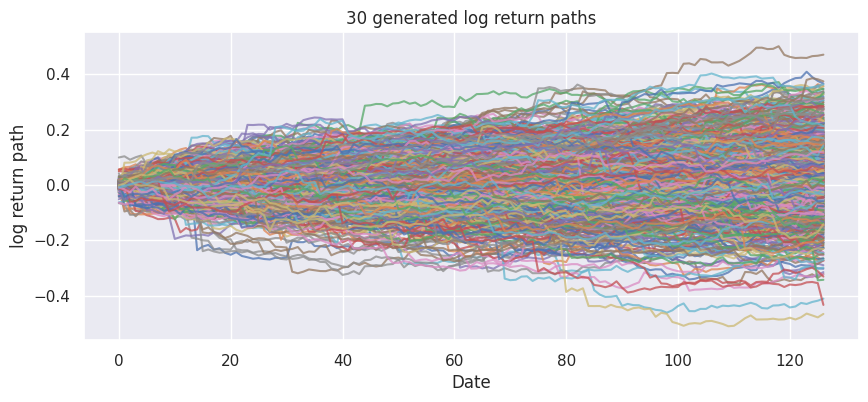

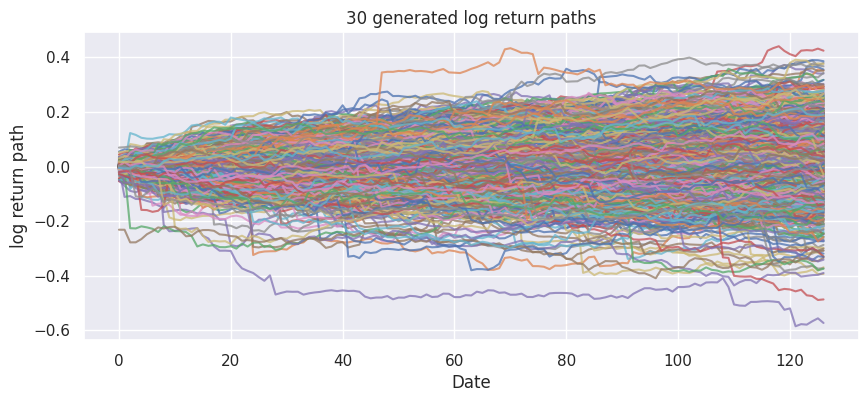

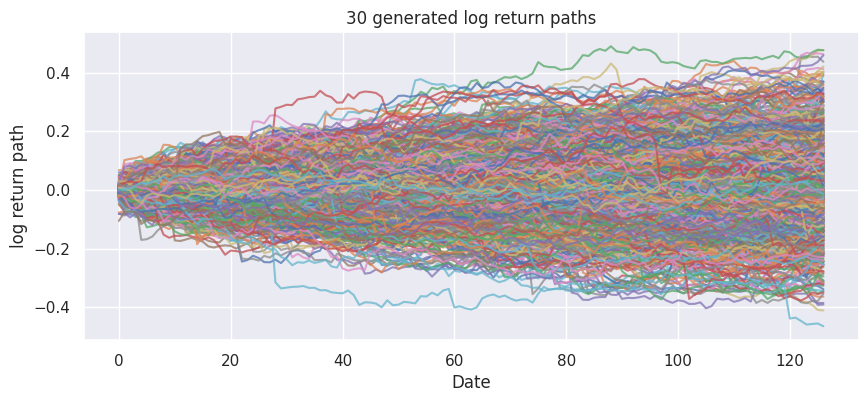

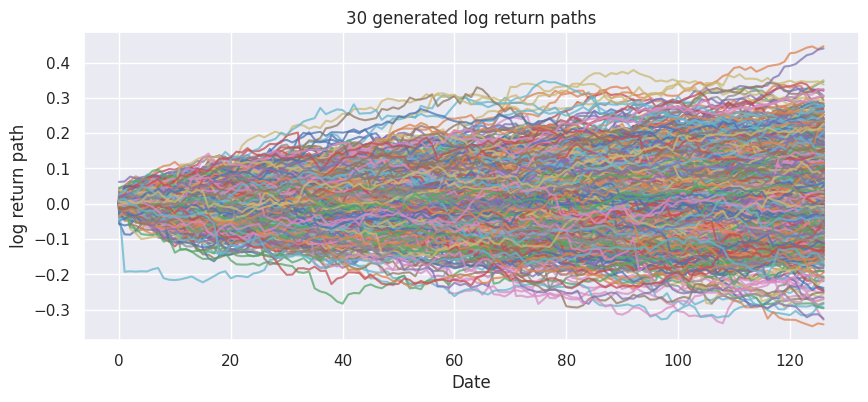

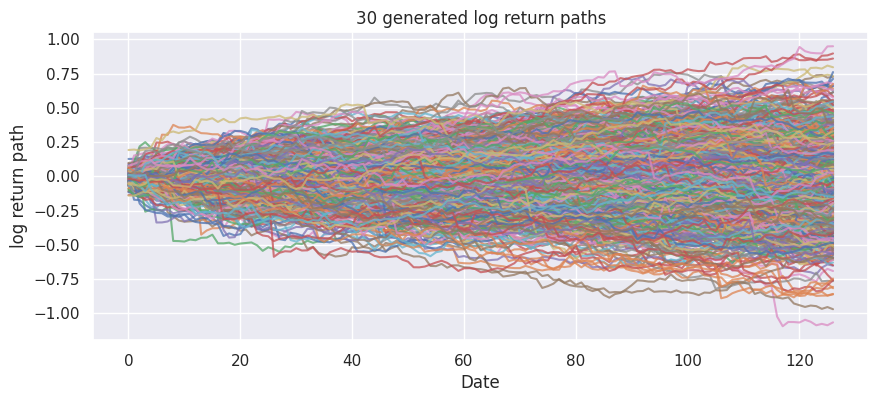

In [8]:
# # plot the 30 generated log return paths
for i in range(5):
    fig, ax = plt.subplots(figsize=(10,4))
    ax.plot(np.cumsum(fake_list[i][0:1000], axis=1).T, alpha=0.75)
    ax.set_title('30 generated log return paths')
    ax.set_xlabel('Date')

    ax.set_ylabel('log return path')

In [9]:
windows = pd.Series([1, 5, 20, 100], name='window size')

# Calculate EMD scores
results_emd = calculate_distribution_scores(real, fake_list, num_G, windows)
results_emd

{'EMD':               EMD 0   EMD 1   EMD 2   EMD 3   EMD 4
 window size                                        
 1            0.0003  0.0003  0.0004  0.0003  0.0009
 5            0.0038  0.0033  0.0019  0.0011  0.0061
 20           0.0123  0.0108  0.0059  0.0032  0.0180
 100          0.0351  0.0321  0.0142  0.0133  0.0707,
 'KL':                KL 0    KL 1    KL 2    KL 3    KL 4
 window size                                        
 1            0.0151  0.0124  0.0133  0.0120  0.0124
 5            0.0482  0.0363  0.0190  0.0165  0.0335
 20           0.1130  0.0883  0.0334  0.0246  0.0701
 100          0.1976  0.1690  0.0793  0.0379  0.1567,
 'JS':                JS 0    JS 1    JS 2    JS 3    JS 4
 window size                                        
 1            0.0598  0.0551  0.0574  0.0545  0.0454
 5            0.1100  0.0962  0.0645  0.0560  0.0788
 20           0.1683  0.1503  0.0840  0.0775  0.1048
 100          0.2208  0.2121  0.1148  0.1018  0.1766,
 'KS':                KS

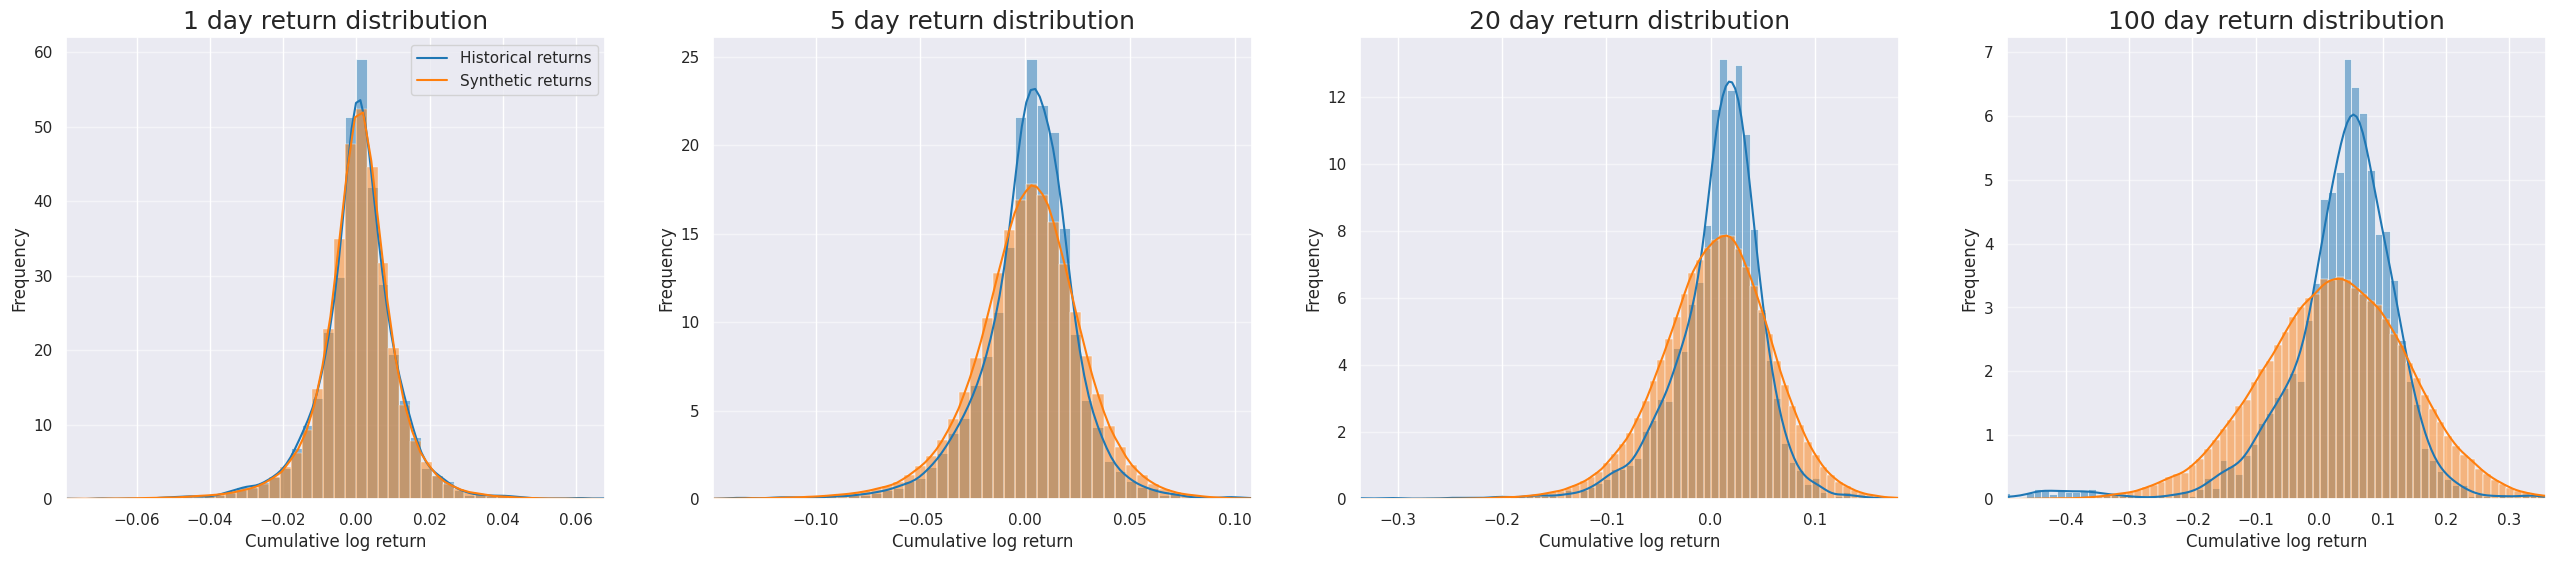

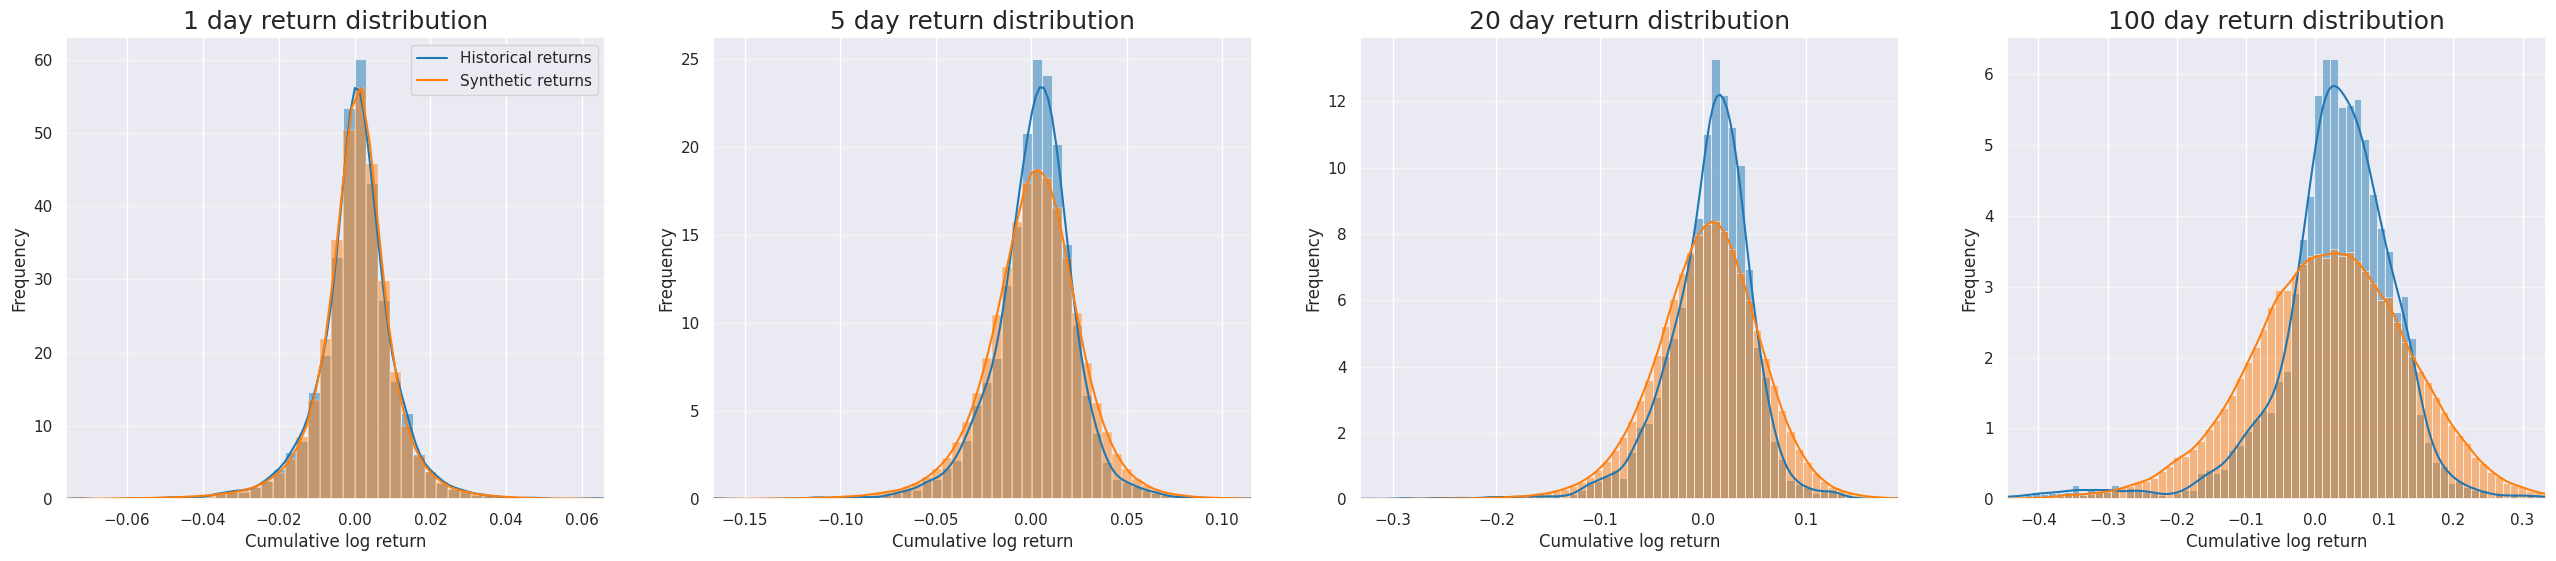

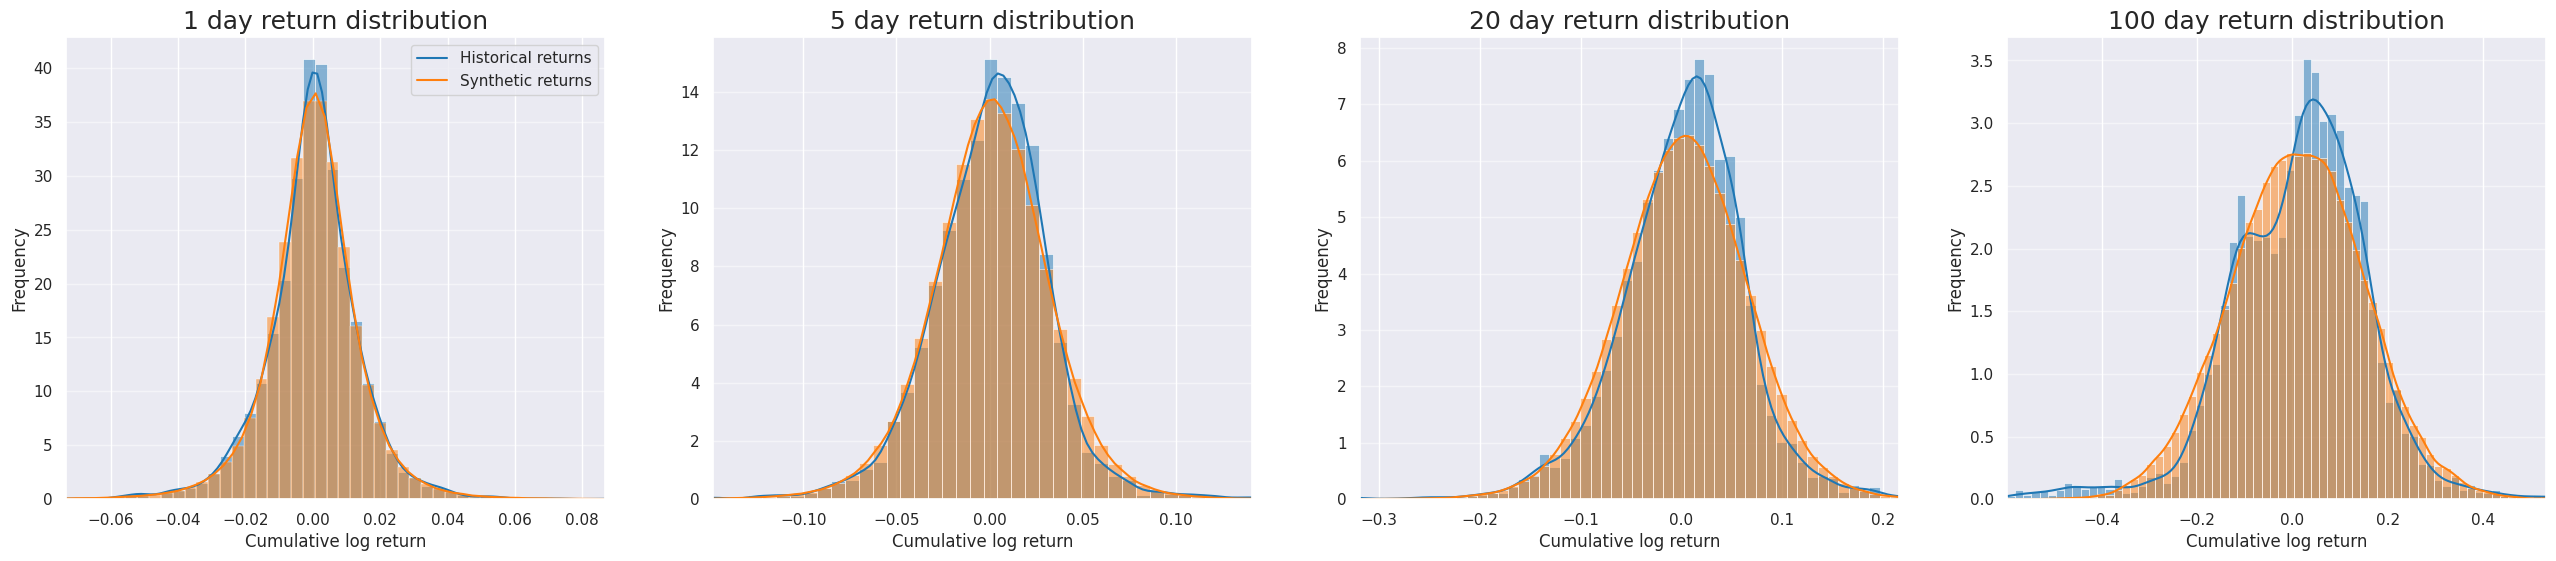

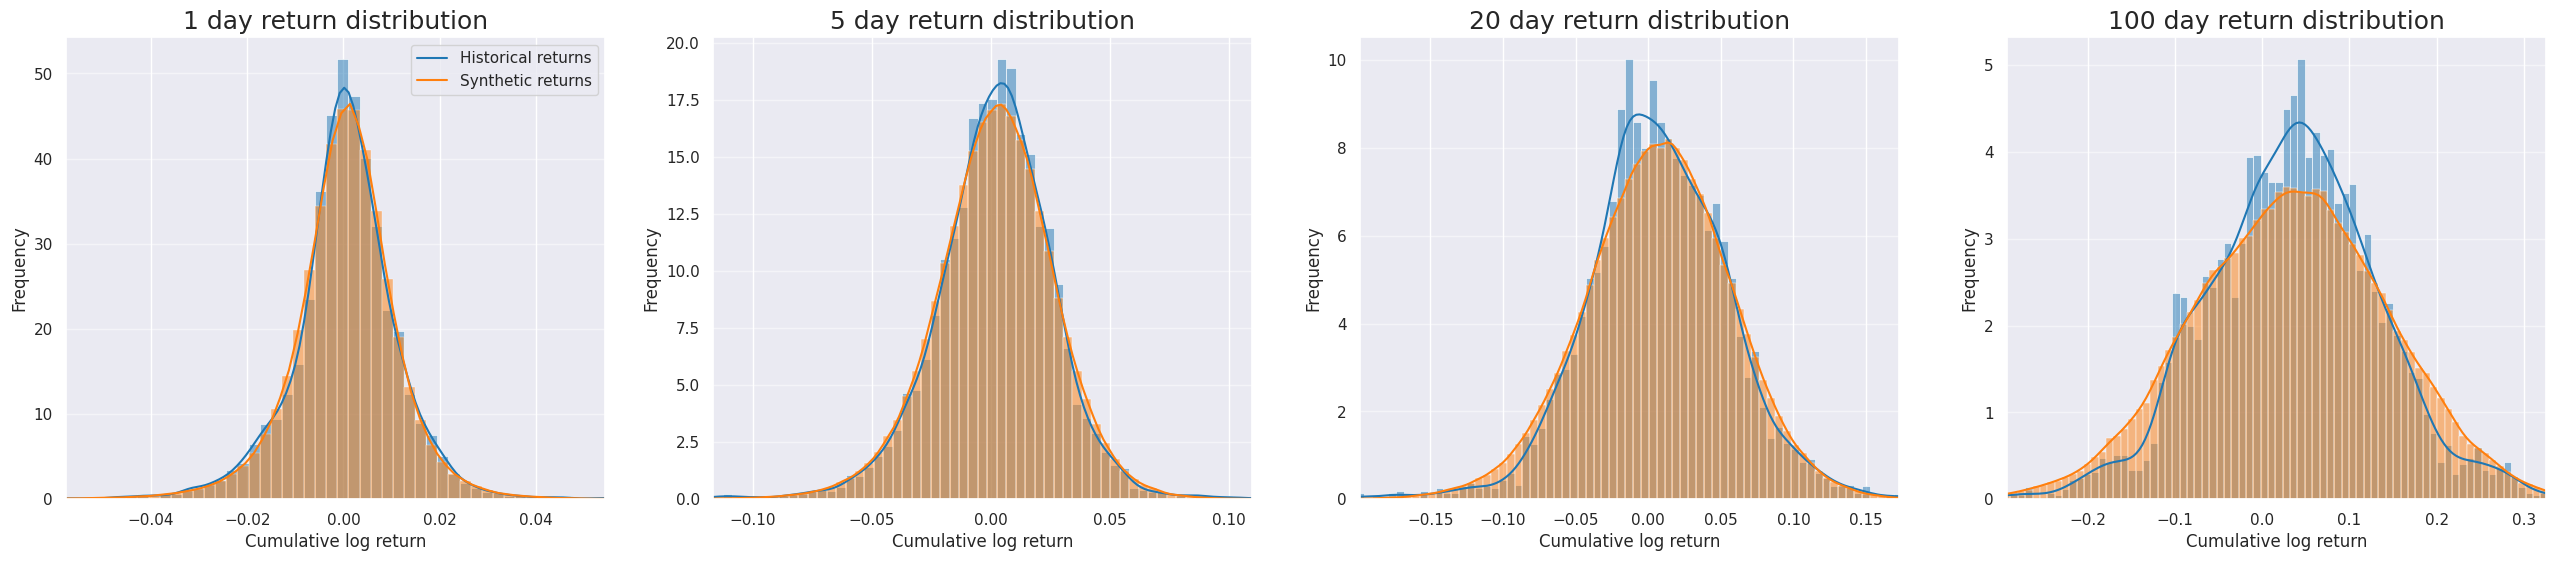

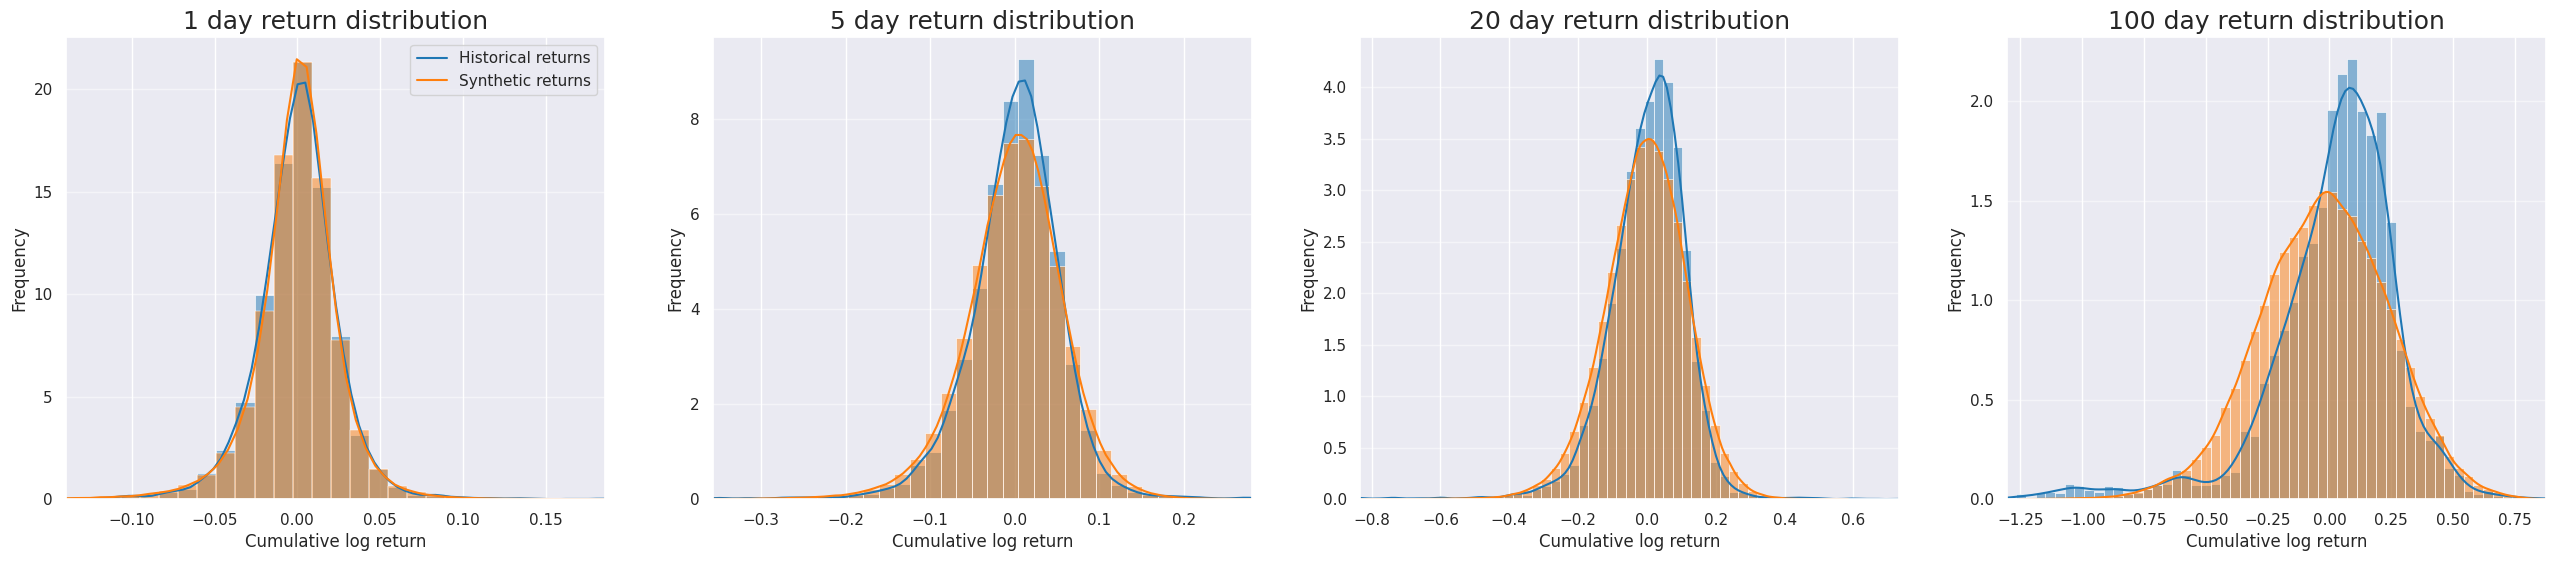

In [10]:
windows = [1, 5, 20, 100]
for j in range(num_G):
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(32, 6))  

    for i in range(len(windows)):
        col = i

        real_dist = rolling_window(real[j], windows[i]).sum(axis=0).ravel()
        fake_dist = rolling_window(fake_list[j].T, windows[i]).sum(axis=0).ravel()
        
        # 두 데이터의 최소값과 최대값을 계산
        min_val = real_dist.min()
        max_val = real_dist.max()

        # 동일한 bin 경계 계산 (간격 동일하게)
        bins = np.linspace(min_val, max_val, 81)  # 80개의 bin 경계 생성
        
        sns.histplot(real_dist, bins=bins, kde=True, ax=axs[col], color='tab:blue', alpha=0.5, stat='density')
        sns.histplot(fake_dist, bins=bins, kde=True, ax=axs[col], color='tab:orange', alpha=0.5, stat='density')

        axs[col].set_xlim(*np.quantile(real_dist, [0.001, .999]))
        
        axs[col].set_title('{} day return distribution'.format(windows[i]), size=18)
        axs[col].yaxis.grid(True, alpha=0.5)
        axs[col].set_xlabel('Cumulative log return', fontsize=12)
        axs[col].set_ylabel('Frequency', fontsize=12)

    axs[0].legend(['Historical returns', 'Synthetic returns'])

plt.show()

In [11]:
# Correlation Analysis of synthetic data
df_fake = []        
for i in range(num_G):
    
    y_tmp, log_returns = inverse_process(fake[:, i:i+1, :].squeeze(), i)        
    df_tmp = pd.DataFrame(y_tmp)
    df_fake.append(df_tmp)
    
df_fake_merge = pd.concat(df_fake, axis=1)

corr_fake, avg_fake, _ = calculate_correlation(df_fake_merge, seq_len)

### Correlation Analysis - real data
real_merge = np.transpose(np.stack(real_list), axes=(1, 0, 2))
real_merge = real_merge.reshape(real_merge.shape[0], -1)
df_real_merge = pd.DataFrame(real_merge)
_, avg_real, _ = calculate_correlation(df_real_merge, seq_len)


Mean of synthetic data correlation
          Asset1    Asset2    Asset3    Asset4    Asset5
Asset1  1.000000  0.083427 -0.021840 -0.018032  0.008899
Asset2  0.083427  1.000000 -0.033215  0.012233 -0.039895
Asset3 -0.021840 -0.033215  1.000000  0.023963  0.056968
Asset4 -0.018032  0.012233  0.023963  1.000000  0.055530
Asset5  0.008899 -0.039895  0.056968  0.055530  1.000000

Standard Deviation of synthetic data correlation
          Asset1    Asset2    Asset3    Asset4    Asset5
Asset1  0.000000  0.087122  0.087846  0.087619  0.082539
Asset2  0.087122  0.000000  0.090297  0.083385  0.083807
Asset3  0.087846  0.090297  0.000000  0.091615  0.088171
Asset4  0.087619  0.083385  0.091615  0.000000  0.088610
Asset5  0.082539  0.083807  0.088171  0.088610  0.000000

Mean of synthetic data correlation
          Asset1    Asset2    Asset3    Asset4    Asset5
Asset1  1.000000  0.960225  0.207354  0.012744  0.232040
Asset2  0.960225  1.000000  0.198390 -0.008253  0.221726
Asset3  0.207354  0.198

In [12]:
mae = calculate_mae(avg_real, avg_fake)
mae_mean, mae_std = calculate_mae_mean(avg_real, corr_fake)

frobenius = calculate_frobenius(avg_real, avg_fake)
spearman = calculate_spearman(avg_real, avg_fake)
kendall = calculate_kendall(avg_real, avg_fake)


print("MAE mean:", mae)
print("Frobenius", frobenius)
print("Spearman", spearman)
print("Kendall:", kendall)
print("MAE mean:", mae_mean, "MAE std:", mae_std)

MAE mean: 0.1717021763350175
Frobenius 1.4319220548304492
Spearman 0.4894941634241245
Kendall: 0.37142857142857144
MAE mean: 0.18377898304535312 MAE std: 0.019559803009801254


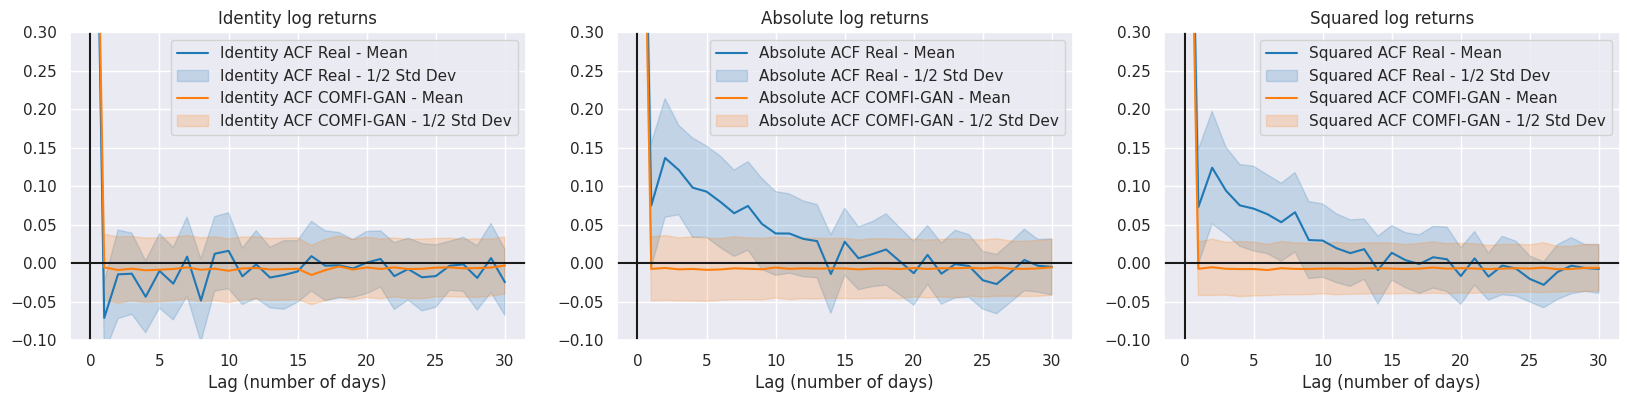

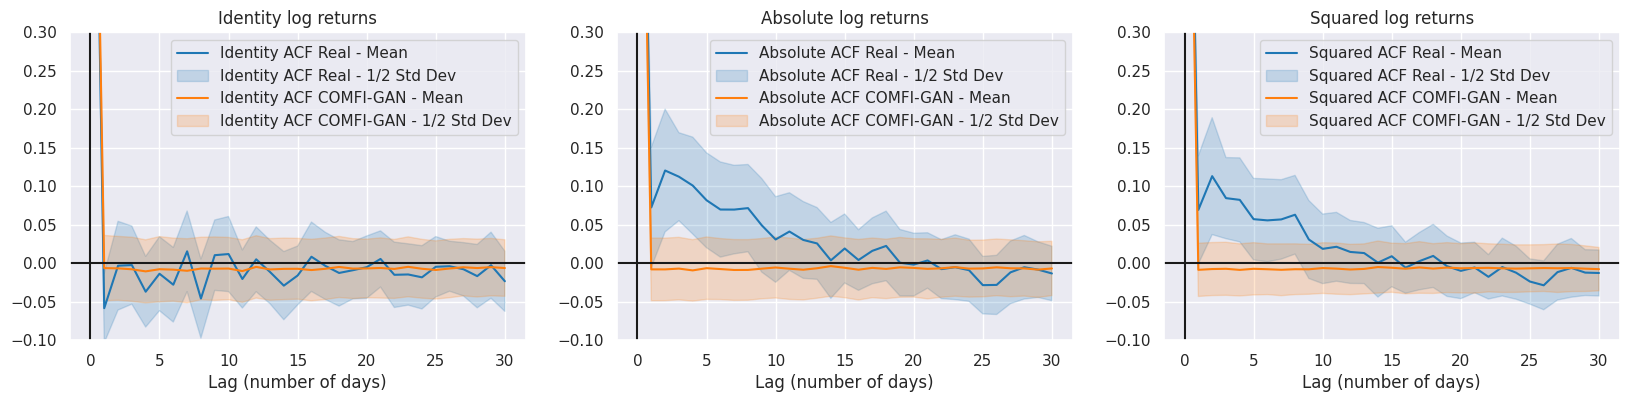

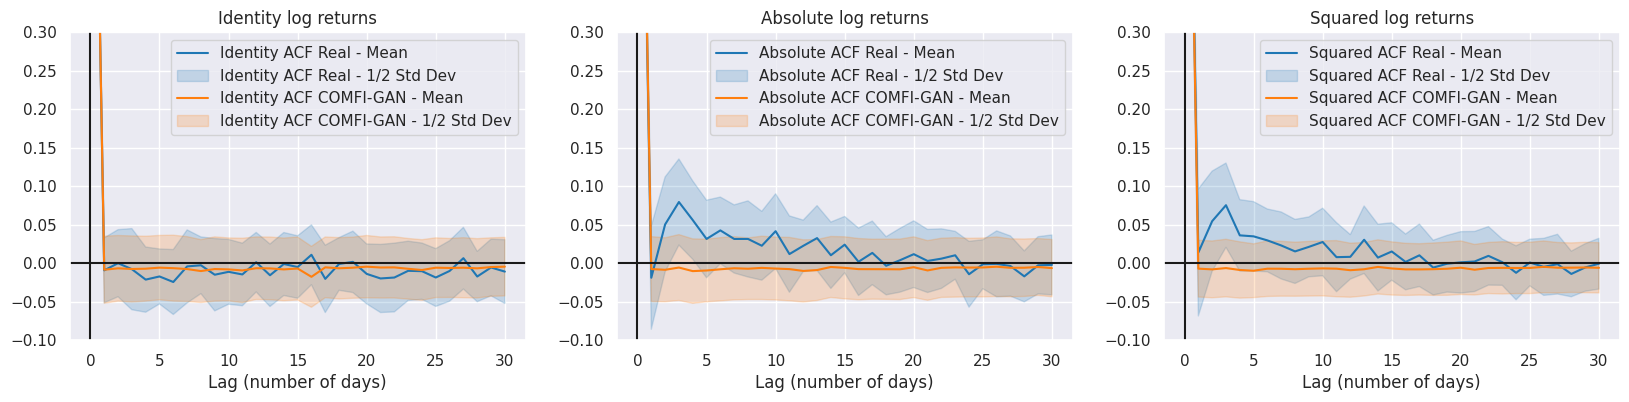

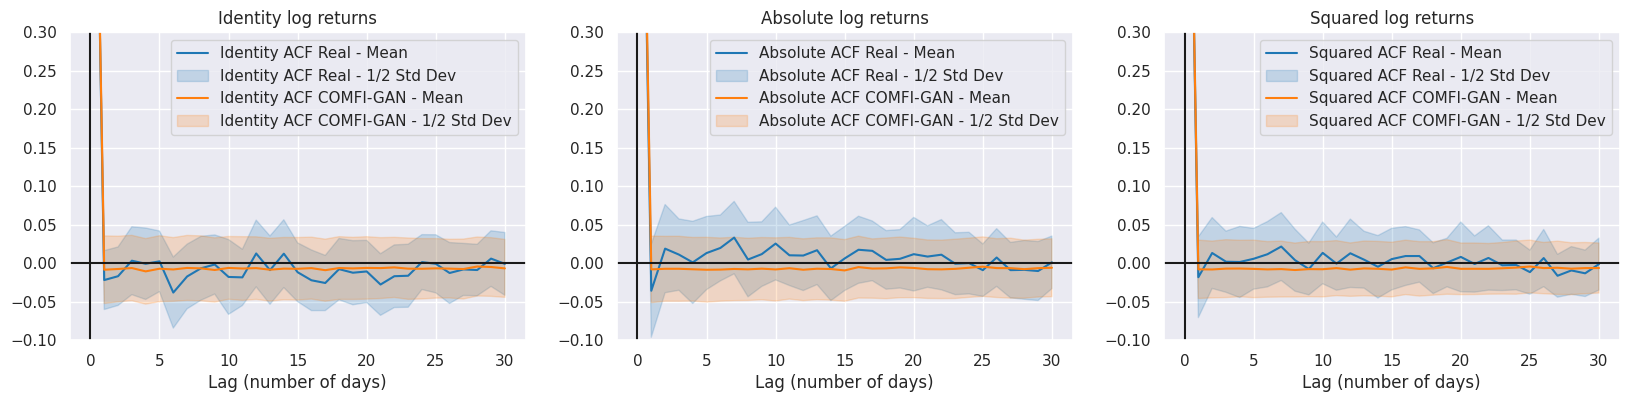

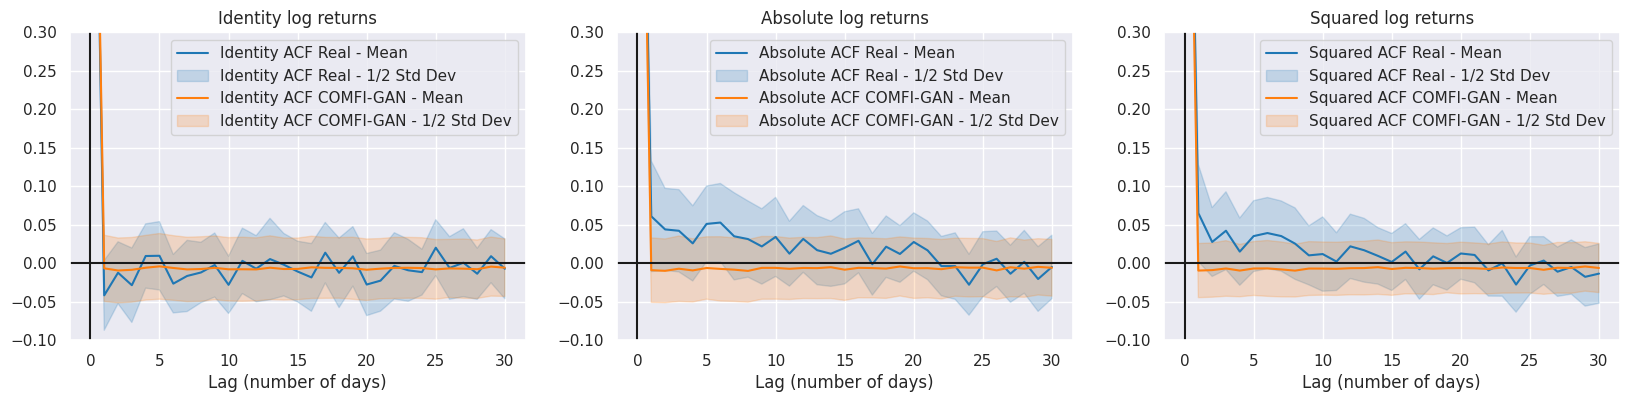

In [13]:
# ACF 비교 플롯
plot_acf_comparison(real_list, fake_list, num_G, lags=30)

In [14]:
acf_score = calculate_acf_score(real_list, fake_list)

# Display the scores for each group
for group, scores in acf_score.items():
    print(f"{group}:")
    for title, score in scores.items():
        print(f"  {title}: {score}")


Group 1:
  Identity log returns: 0.1054
  Absolute log returns: 0.3145
  Squared log returns: 0.2592
Group 2:
  Identity log returns: 0.0932
  Absolute log returns: 0.2975
  Squared log returns: 0.2455
Group 3:
  Identity log returns: 0.0561
  Absolute log returns: 0.178
  Squared log returns: 0.1536
Group 4:
  Identity log returns: 0.0649
  Absolute log returns: 0.1023
  Squared log returns: 0.0706
Group 5:
  Identity log returns: 0.0764
  Absolute log returns: 0.1816
  Squared log returns: 0.1469
